In [1]:
from __future__ import division
from scipy import *
from scipy import special
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm                # colourmap
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Boundary element method in axisymmetry
#### Tan Beng Hau, Cavitation Lab

In this notebook I solve the Laplace equation under axisymmetry. The basic functions used for the boundary element solver are explained in greater detail in Ang Whye Teong's excellent book, or see [my other iPython notebook on solving the boundary element method in 2D](http://nbviewer.ipython.org/github/bhit/numerical-methods/blob/master/Boundary%20element%20method%20-%202D%20Laplace.ipynb). 

In general there are certain singular integrals to be handled (a comprehensive treatment can be found in Bachok bin Taib's thesis) but in this notebook I don't handle them. The reciprocal relation or line integral version of the boundary element equation is 

$$ \lambda(\xi,\eta) \phi(\xi,\eta) = \int_c \left[ \phi \frac{\partial \Phi_{\rm 3D}}{\partial n}  - \Phi_{\rm 3D} \frac{\partial \phi}{\partial n} \right] dS, $$

where the fundamental solution of the three-dimensional Green equation is

$$ \Phi_{\rm 3D} = - \frac{1}{4\pi \sqrt{(x-\xi)^2 + (y-\eta)^2 + (z - \zeta)^2}} $$

and the infinitesimal area $dS$ is written as

$$ dS(x,y,z) = r d\ell d\theta.$$

To convert this to the axisymmetric equivalent (see Bachok bin Taib's thesis, or the notes by Ang Whye Teong), a change of coordinates leads to the form

$$ \Phi_{\rm axi}(r,z; r_0, z_0) = -\frac{1}{\pi \sqrt{(r+r_0)^2 + (z-z_0)^2}} K\left( \frac{4 r r_0}{(r+r_0)^2 + (z-z_0)^2} \right), $$

where $K(k)$ is the complete elliptic integral of the first kind, and 

$$ \frac{\partial \Phi}{\partial n} = - \frac{1}{\pi\sqrt{(r+r_0)^2 + (z-z_0)^2}}\times\left[ \frac{n_r}{2r} \left(\frac{r_0^2 - r^2}{(r+r_0)^2 + (z-z_0)^2} E \left( \frac{4 r r_0}{(r+r_0)^2 + (z-z_0)^2} \right) - K\left( \frac{4r r_0}{(r+r_0)^2 + (z-z_0)^2} \right) \right) \right] $$

## Evaluating the line integrals

Points along the boundary elements can be described with

$$ r = r^{(k)} - t\ell^{(k)} n_z^{(k)}, $$

$$ z = z^{(k)} + t\ell^{(k)} n_r^{(k)},$$

where $t\in (0,1)$ and the length of the element is defined as

$$ \ell^{(k)} = \sqrt{(r-r_0)^2 + (z - z_0)^2}. $$

The normal vectors are described by

$$ [n_r^{(k)}, n_z^{(k)} ] = [z^{(k+1)} - z^{(k)}, r^{(k)} - r^{(k+1)}]/\ell^{(k)} $$

Also, note that 

$$ dS(r,z) = \sqrt{(dr)^2 + (dz)^2} = \ell^{(k)} dt. $$

## Line integrals

After transformation, the free space Green function is

$$ \int_S \Phi_{\rm axi} dS = \int_0^1 dt \frac{4 r \ell^{(k)} }{\sqrt{(r+r_0)^2 + (z-z_0)^2}} K \left( \frac{4 r r_0}{(r+r_0)^2 + (z-z_0)^2} \right).$$

The normal derivative of the free space Green function is 

$$ \int_S \frac{\partial\Phi}{\partial n} dS = \int_0^1 -\frac{4 r \ell^{(k)} dt}{\pi \sqrt{(r+r_0)^2 + (z-z_0)^2}} \left[ \frac{n_r}{2r} \left(\frac{r_0^2 - r^2 + (z-z_0)^2}{(r-r_0)^2 + (z-z_0)^2} E\left( \frac{4 r r_0}{(r+r_0)^2 + (z-z_0)^2}\right) - K\left( \frac{4 r r_0}{(r+r_0)^2 + (z-z_0)^2} \right) \right) + n_z \frac{z_0 - z}{(r-r_0)^2 + (z-z_0)^2} E\left( \frac{4rr_0}{(r+r_0)^2 + (z-z_0)^2} \right) \right]. $$

Note that these quantities require an integral in $t$, which we will evaluate with Gauss quadrature. 

## Complete elliptic integrals of the first and second kind

These approximations come from Abramowitz and Stegun. `scipy` also provides a function for both integrals, which is possibly based on the same formulas in A&S. 

In [2]:
def ell_k(m):
    a0 = 1.38629436112
    a1 = 0.09666344259
    a2 = 0.03590092383
    a3 = 0.03742563713
    a4 = 0.01451196212
    b0 = 0.5
    b1 = 0.12498593597
    b2 = 0.06880248576
    b3 = 0.03328355346
    b4 = 0.00441787012    
    m1 = 1 - m
    ell_1 = a0 + a1*m1 + a2*m1**2 + a3*m1**3 + a4*m1**4
    ell_2 = (b0 + b1*m1 + b2*m1**2 +a3*m1**3 + a4*m1**4) * log(1./m1)
    
    return ell_1 + ell_2

def ell_e(m):
    a1 = .44325141463
    a2 = .06260601220
    a3 = .04757383546
    a4 = .01736506451
    b1 = .24998368310
    b2 = .09200180037
    b3 = .04069697526
    b4 = .00526449639
    m1 = 1-m
    
    el_1 = 1 + a1*m1 + a2*m1**2 + a3*m1**3 + a4*m1**4
    el_2 = (b1*m1 + b2*m1**2 + b3*m1**3 + b4*m1**4) * log(1./m1)
    
    return el_1 + el_2
    

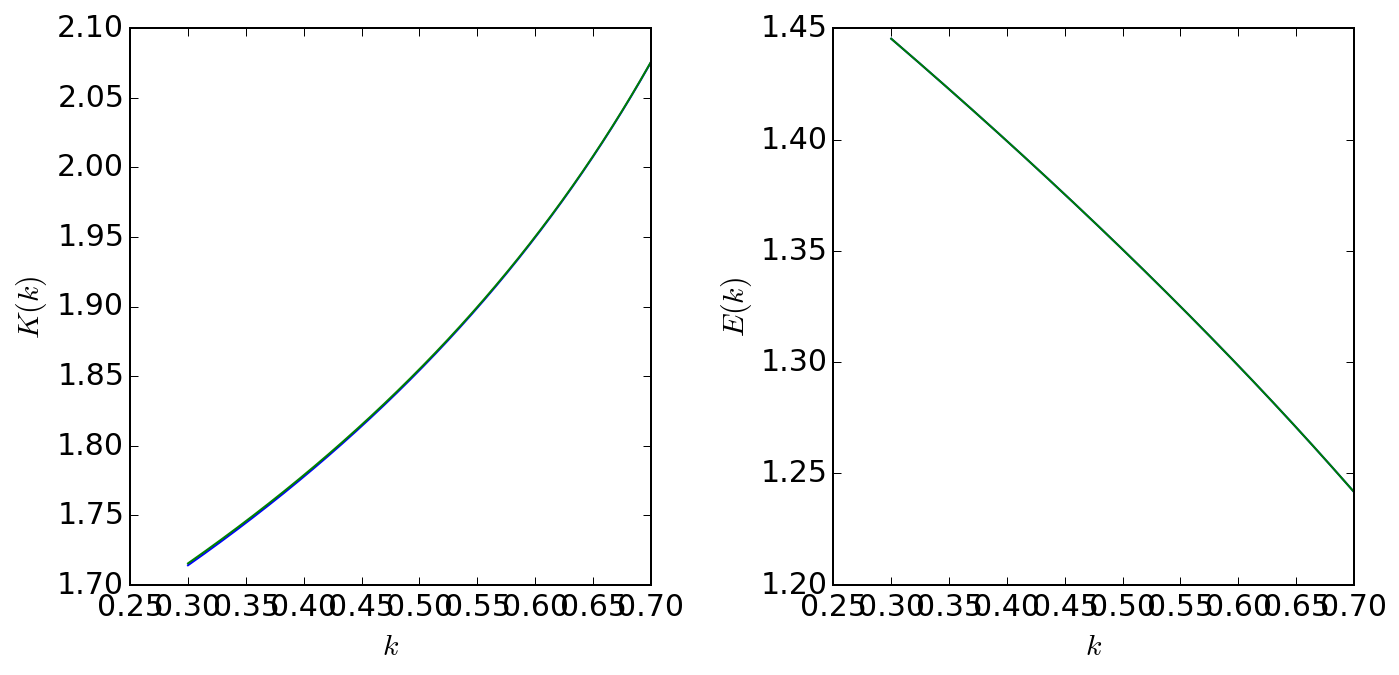

In [3]:
plt.figure(figsize=(10,5))
plt.rcParams['font.size'] = 15
plt.subplot(121)
x = linspace(0.3, 0.7, 1000)
y = special.ellipk(x)
z = ell_k(x)
plt.plot(x,y)
plt.plot(x,z)
plt.xlabel('$k$')
plt.ylabel('$K(k)$')

plt.subplot(122)
x = linspace(0.3, 0.7, 1000)
w = special.ellipe(x)
q = ell_e(x)
plt.plot(x,w)
plt.plot(x,q)
plt.xlabel('$k$')
plt.ylabel('$E(k)$')
plt.tight_layout()

## Gauss quadrature 

Integrals may be approximated as

$$ \int_{-1}^1 f(x) dx = \sum_{i=1}^n w_i f(x_i), $$ 

where $x_i$ are the nodes and $w_i$ are the quadrature weights. To integrate from 0 to 1 we just have to halve the integral. 

It is possible to solve for the $n$ quadrature weights with Legendre polynomials. The great thing about Gauss quadrature is that the weights only have to be computed once. Naturally, others have already computed quadrature weights for various values of $n$. The nodes and weights of the $n$-point Gauss-Legendre integration [are tabulated in various resources](http://keisan.casio.com/exec/system/1280624821). 

In [4]:
# 8 point Gauss quadrature, integrating from 0 to 1.
def gauss_quad(func):
    x1 = -0.9602898564975362316836; x2 = -0.7966664774136267395916
    x3 = -0.5255324099163289858177; x4 = -0.1834346424956498049395
    x5 = -x4; x6 = -x3; x7 = -x2; x8 = -x1
    
    w1 = 0.101228536290376259153; w2 = 0.222381034453374470544
    w3 = 0.313706645877887287338; w4 = 0.362683783378361982965
    w5 = w4; w6 = w3; w7 = w2; w8 = w1
    
    w = [w1, w2, w3, w4, w5, w6, w7, w8]
    x = [x1, x2, x3, x4, x5, x6, x7, x8]
    mysum = 0
    
    for i in range(len(w)):
        mysum += w[i]*func(x[i])
    
    return mysum/2

In [5]:
def quadraticfunc(x):
    return x**2
print gauss_quad(quadraticfunc)

0.333333333333


## Bessel functions

There also exist polynomial approximations for Bessel functions, but for this code I will take a shortcut and use `scipy.special`. 

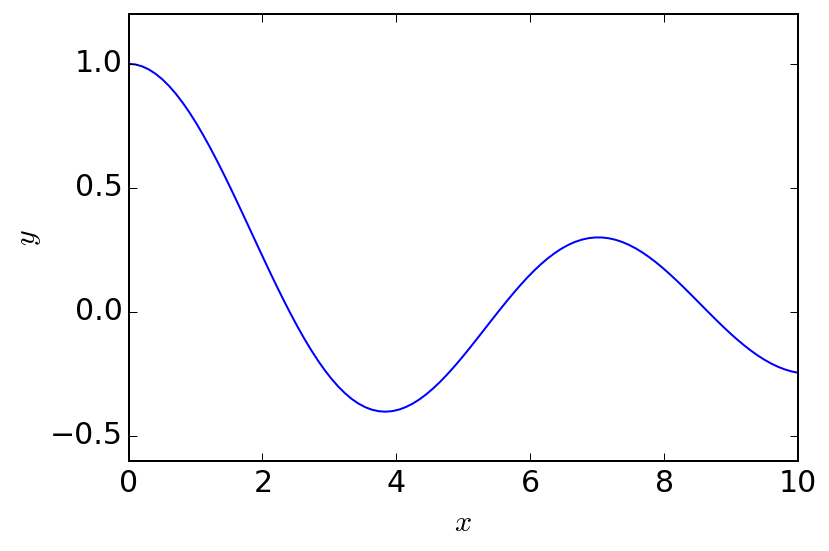

In [6]:
from scipy import special
x = linspace(0,10,100)
y = special.jv(0,x)
plt.plot(x,y)
plt.xlabel('$x$'); plt.ylabel('$y$')

## Numerical solution

Here I am solving a similar problem to that handled by Pablo Suarez. We consider a square domain on the $O(rz)$ plane. On the 'right' wall $r=1$, $\phi = J_0(1) (e^{z} + e^{-z})$. On the top wall $z=1$, the normal derivative of the potential is $d\phi/dn = J_0(r) (e^z - e^{-z})$, and on the bottom wall $z=0$ the normal derivative is $d\phi/dn = 0$. 

Some of the code (such as the setup of the solution domain) comes from Claus-Dieter Ohl's lecture notes. 

**An important note**: the axis of symmetry $r=0$ (ie, the 'left wall') is not discretised.

In [7]:


"""
Returns approximations of the complete elliptic integrals 
of the first and second kind (Abramowitz and Stegun).
"""
def ell_int(m):

    m1 = 1 - m
    
    a0 = 1.38629436112
    a1 = 0.09666344259
    a2 = 0.03590092383
    a3 = 0.03742563713
    a4 = 0.01451196212
    b0 = 0.5
    b1 = 0.12498593597
    b2 = 0.06880248576
    b3 = 0.03328355346
    b4 = 0.00441787012        

    ell_1 = a0 + a1*m1 + a2*m1**2 + a3*m1**3 + a4*m1**4
    ell_2 = (b0 + b1*m1 + b2*m1**2 +a3*m1**3 + a4*m1**4) * log(1./m1)

    c1 = .44325141463
    c2 = .06260601220
    c3 = .04757383546
    c4 = .01736506451
    d1 = .24998368310
    d2 = .09200180037
    d3 = .04069697526
    d4 = .00526449639

    el_1 = 1 + c1*m1 + c2*m1**2 + c3*m1**3 + c4*m1**4
    el_2 = (d1*m1 + d2*m1**2 + d3*m1**3 + d4*m1**4) * log(1./m1)    

    ell_K = ell_1 + ell_2
    ell_E = el_1 + el_2

    return ell_K, ell_E

"""
Perform the line integrals for the free space and normal derivative
Green's functions. The integrals are performed over the parameter t
with a Gauss quadrature of 8 points.
"""
def CPF(xir, etaz, rk, zk, nkr, nkz, L):

    # Gauss quadrature 
    x1 = -0.9602898564975362316836; x2 = -0.7966664774136267395916
    x3 = -0.5255324099163289858177; x4 = -0.1834346424956498049395
    x5 = -x4; x6 = -x3; x7 = -x2; x8 = -x1

    t1 = .5* -0.9602898564975362 + .5
    t2 = .5* -0.7966664774136267 + .5
    t3 = .5* -0.525532409916329  + .5
    t4 = .5* -0.1834346424956499 + .5
    t5 = .5*  0.1834346424956499 + .5
    t6 = .5*  0.525532409916329  + .5
    t7 = .5*  0.7966664774136267 + .5
    t8 = .5*  0.9602898564975362 + .5    
       
    w1 = 0.101228536290376259153; w2 = 0.222381034453374470544
    w3 = 0.313706645877887287338; w4 = 0.362683783378361982965
    w5 = w4; w6 = w3; w7 = w2; w8 = w1
    
    w = [w1, w2, w3, w4, w5, w6, w7, w8]
    t = [x1, x2, x3, x4, x5, x6, x7, x8]
    # t = [t1, t2, t3, t4, t5, t6, t7, t8]

    PF1 = 0; PF2 = 0

    for i in range(8):
        r = rk - t[i]*L*nkz     # r in parameter r(t)
        z = zk + t[i]*L*nkr     # z in parameter z(t)

        # argument in the elliptic integral to be evaluated
        m = 4*r*xir / ((r+xir)**2 + (z-etaz)**2)

        # Retrieve the elliptic integrals
        CK, CE =  ell_int(m)
        # CK = special.ellipk(m)
        # CE = special.ellipe(m)

        # Integrate w.r.t the parameter
        PF1 = PF1 + 0.5*w[i]*4*r*L * CK / sqrt( (r+xir)**2 + (z-etaz)**2 )

        A = -4 / sqrt((r+xir)**2 + (z-etaz)**2)
        B = (r**2 - xir**2 - (z-etaz)**2) \
            /((r - xir)**2 + (z - etaz)**2)
        C = (z - etaz) / ((r-xir)**2 + (z-etaz)**2)

        PF2 =  PF2 + 0.5*w[i]*r*L *\
               A*(nkr/(2*r)*(CK+B*CE) + C*CE*nkz )
        
    return PF1, PF2

        
def CELAP1(N, xm, ym, xb, yb, nx, ny, lg, BCT, BCV):

    A = zeros((N,N)); B = zeros(N)
    phi = zeros(N); dphi = zeros(N)
    
    for m in range(N):
        for k in range(N):
            PF1, PF2 = CPF(xm[m], ym[m], xb[k], yb[k], nx[k], ny[k], lg[k])
            F1 = PF1/(2*pi)
            F2 = PF2/(2*pi)

            if (k==m):
                delta = 1.
            else:
                delta = 0.

            if (BCT[k] == 0):
                A[m,k] = -F1
                B[m] = B[m] + BCV[k] * (-F2 + 0.5*delta)
            else:
                A[m,k] = F2 - 0.5* delta
                B[m] = B[m] + BCV[k] * F1

    # solve
    Z = np.linalg.solve(A,B)

    for m in range(N):
        if (BCT[m] == 0):
            phi[m] = BCV[m]
            dphi[m] = Z[m]
        else:
            phi[m] = Z[m]
            dphi[m] = BCV[m]

    # return the potential
    return phi, dphi
            
def CELAP2(N, xi, eta, xb, yb, nx, ny, lg, phi, dphi):

    my_sum = 0
    for i in range(N):
        PF1, PF2 = CPF(xi, eta, xb[i], yb[i], nx[i], ny[i], lg[i])
        my_sum = my_sum + phi[i]* PF2 - dphi[i] * PF1

    return -my_sum/pi

In [8]:

#number of elements per side
N0=100
#total number of elements
N=3*N0
dl=1./N0 #all boundary elements are of the same length (check!)
#position of the corners
rb=np.zeros(N+1)
zb=np.zeros(N+1)
#position of the midpoints
rm=np.zeros(N)
zm=np.zeros(N)
#length of each element
lg=np.zeros(N)
#normal vector
nr=np.zeros(N)
nz=np.zeros(N)
#type of boundary condition
BCT=np.zeros(N)
#Value of boundary condition
BCV=np.zeros(N)

#define the positions of the boundaries
for i in range(N0):
    rb[i]=i*dl           #bottom: normal derivative 0
    zb[i]=0.
    rb[N0+i]=1.          #right: potential J0(1)*(exp(z) + exp(-z))
    zb[N0+i]=rb[i]
    rb[2*N0+i]=1.-rb[i]  #top: normal derivative is J0(r) *(exp(1) - exp(-1))
    zb[2*N0+i]=1.
    # rb[3*N0+i]=0.        #left We don't discretise here!
    # zb[3*N0+i]=1.-rb[i]
#extend for simplicity of calculations
rb[N]=0
zb[N]=1

# Calculate midpoints
for i in range(N):
    rm[i]=.5*(rb[i]+rb[i+1]) #midpoint
    zm[i]=.5*(zb[i]+zb[i+1])
    lg[i]= sqrt((rb[i+1]-rb[i])**2.+(zb[i+1]-zb[i])**2.) #length
    nr[i]=(zb[i+1]-zb[i])/lg[i] #normal vector
    nz[i]=(rb[i]-rb[i+1])/lg[i]

# print lg

# Specify the boundary conditions
for i in range(N):
    
    #right: potential J0(1)*(exp(z) + exp(-z))
    if (i>=N0) or (i < 2*N0):    
        BCT[i] = 0
        BCV[i] = special.jv(0, rm[i]) * (exp(zm[i]) + exp(-zm[i]))

    #top: normal derivative is J0(r) *(exp(1) - exp(-1))        
    elif (i >= 2*N0):
        BCT[i] = 1
        BCV[i] = special.jv(0, rm[i]) * (exp(zm[i]) - exp(-zm[i]))

    # bottom
    else:
        BCT[i] = 1
        BCV[i] = 0.


phi, dphi = CELAP1(N, rm, zm, rb, zb, nr, nz, lg, BCT, BCV)
Npint = 10
r = linspace(0.1,0.9, Npint)
z = linspace(0.1,0.9, Npint)
R, Z= meshgrid(r,z)

phi_bem = zeros((Npint, Npint))
phi_ana = zeros((Npint, Npint))
for i in range(R.size):
    phi_bem.flat[i]=CELAP2(N,R.flat[i],Z.flat[i],rb,zb,nr,nz,lg,phi,dphi)
    phi_ana.flat[i] = special.jv(0, R.flat[i])*(exp(Z.flat[i]) + exp(-Z.flat[i]))

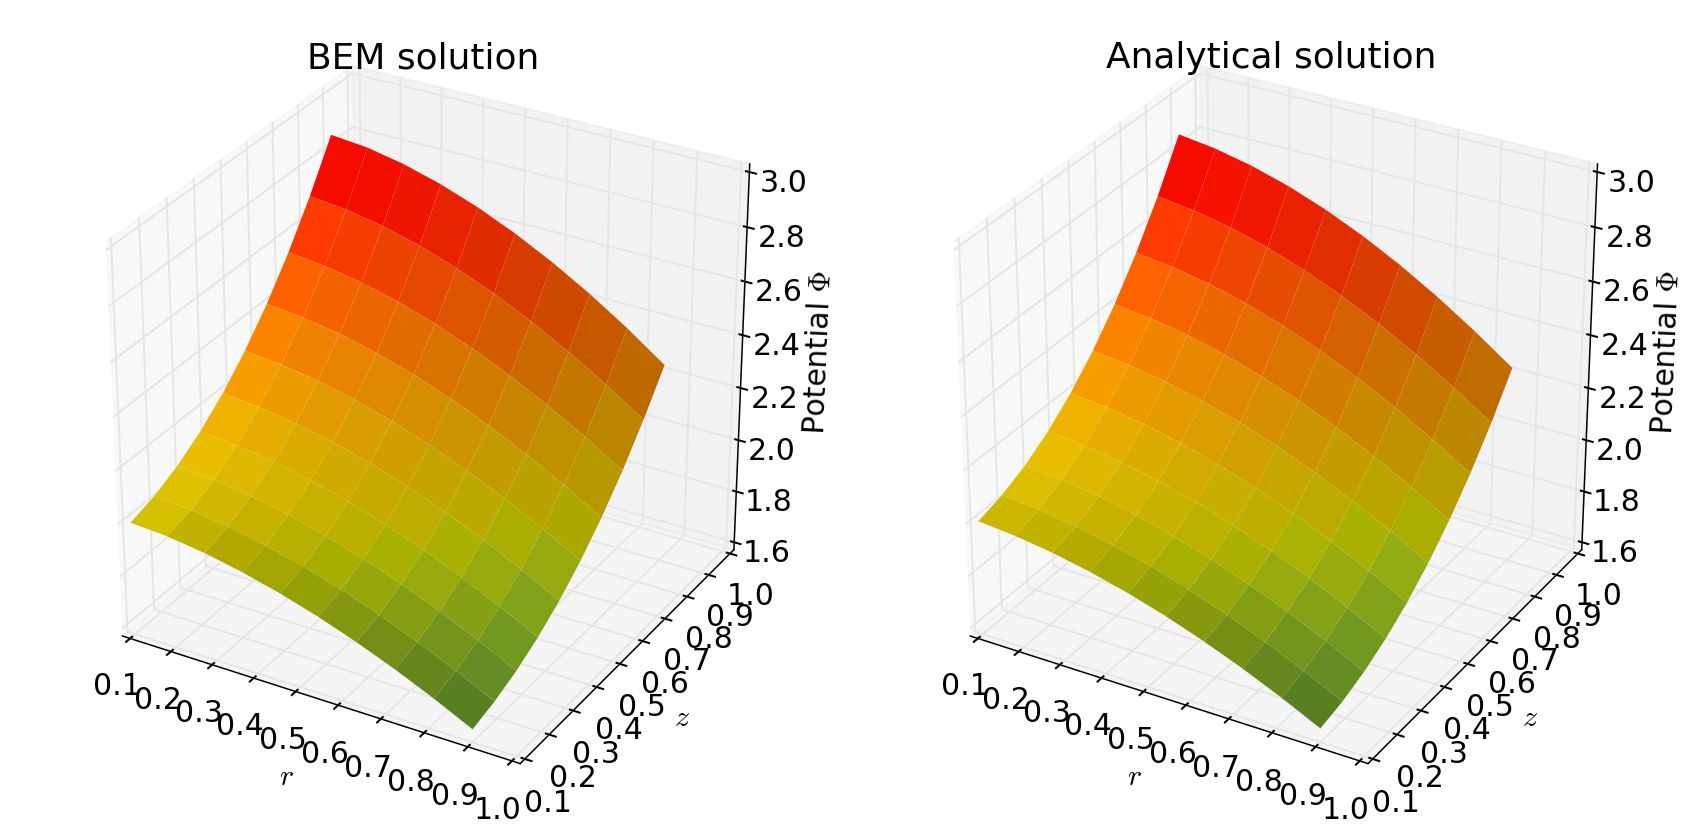

In [9]:
fig = plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = 15

N1 = phi_bem[:]/1.
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(R, Z, phi_bem, linewidth=0, facecolors=cm.jet(N1/3), 
                rstride=1, cstride=1 )
ax.set_xlabel('$r$')
ax.set_ylabel('$z$')
ax.set_zlabel('Potential $\Phi$')
ax.set_title('BEM solution')


N2 = phi_ana[:]/1.
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(R, Z, phi_ana, linewidth=0, facecolors=cm.jet(N2/3), 
                rstride=1, cstride=1 )
ax.set_xlabel('$r$')
ax.set_ylabel('$z$')
ax.set_zlabel('Potential $\Phi$')
ax.set_title('Analytical solution')

plt.tight_layout()